In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#1. import data
df = df=pd.read_pickle(r"cust_final_20191030.pkl")

In [3]:
dfcl = df[(df["PRODUCT_GROUP"]=='CL') & (df["RISK_AGRF120"]==1)]

In [4]:
dfcl.TIME_DECISION_DATE.dt.year.value_counts()

2018    39099
2019    19248
2017    11921
2016     2052
2015      414
2014        7
Name: TIME_DECISION_DATE, dtype: int64

In [5]:
dfcl['TIME_GAP']=(dfcl['TIME_DECISION_DATE_max']-dfcl['ACTIVITY_DATE_max']).dt.days

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


4644
1


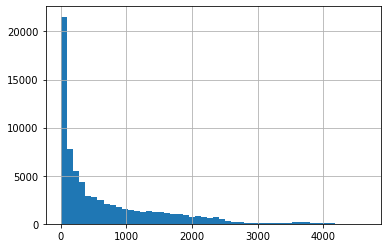

In [6]:
print(dfcl['TIME_GAP'].max())
print(dfcl['TIME_GAP'].min())
dfcl[dfcl["PRODUCT_GROUP"]=='CL']['TIME_GAP'].hist(bins=50)

In [7]:
Xcl= dfcl.drop(columns=["PRODUCT_GROUP","TIME_DECISION_DATE_max","ACTIVITY_DATE_min","ACTIVITY_DATE_max","CLIENT_EXI_3M"])

In [8]:
loaded_modelcl = pickle.load(open(r"xgb_cl_fstq_wo_hc.mod",'rb'))

In [9]:
feature_listcl = ['ACTIVITY_VALUE_std', 'month_nunique_DEBIT_1000_Earn', 'mesdq_max', 'month_nunique_GROCERY_1000_Earn', 'ALLOCATED_POINTS_std', 'month_nunique_DEBIT_90_by_1000_Earn', 'ALLOCATED_POINTS_std_GROCERY_1000_Earn', 'ALLOCATED_POINTS_sum_DEBIT_90_by_1000_Earn', 'ALLOCATED_POINTS_mean_E_WALLET_365_Earn', 'ALLOCATED_POINTS_EARN_LAG3', 'ALLOCATED_POINTS_std_E_WALLET_1000_Earn', 'ALLOCATED_POINTS_median_E_WALLET_180_Earn', 'month_nunique_FUEL_1000_Earn', 'ALLOCATED_POINTS_mean_DEBIT_90_by_1000_Earn', 'ALLOCATED_POINTS_max_APPAREL_365_Earn', 'ALLOCATED_POINTS_sum_365_Burn', 'ALLOCATED_POINTS_mean_E_WALLET_180_Earn', 'ALLOCATED_POINTS_max_DEBIT_1000_Earn', 'ALLOCATED_POINTS_mean_E_WALLET_365_by_1000_Earn', 'ALLOCATED_POINTS_sum_DEBIT_1000_Earn', 'ACTIVITY_VALUE_median_GROCERY_1000_Earn', 'ALLOCATED_POINTS_sum_180_Burn', 'ACTIVITY_VALUE_median_E_WALLET_180_Earn']

In [10]:
y_predcl= loaded_modelcl.predict_proba(Xcl[feature_listcl],ntree_limit= loaded_modelcl.best_ntree_limit)[:,1]
print("Blended Gini", 2*metrics.roc_auc_score(Xcl['RISK_FSTQPD30'], y_predcl)-1)

Blended Gini 0.3205238349448054


In [12]:
for i in np.arange(1,12):
    X_temp = Xcl[(Xcl["TIME_GAP"] >= (i-1)*360) & (Xcl["TIME_GAP"] < (i*360)-1)]
    y_predcl= loaded_modelcl.predict_proba(X_temp[feature_listcl],ntree_limit= loaded_modelcl.best_ntree_limit)[:,1]
    print(round(X_temp['RISK_FSTQPD30'].sum()*100/X_temp.shape[0],2),"% ","Count: ",X_temp.shape[0]," Iteration :",i," Time Gap Low: ",(i-1)*360," Time Gap High: ",(i*360)-1," Gini:", 2*metrics.roc_auc_score(X_temp['RISK_FSTQPD30'], y_predcl)-1)

2.19 %  Count:  38579  Iteration : 1  Time Gap Low:  0  Time Gap High:  359  Gini: 0.3350389532423885
2.11 %  Count:  10174  Iteration : 2  Time Gap Low:  360  Time Gap High:  719  Gini: 0.2973115354348175
2.43 %  Count:  6706  Iteration : 3  Time Gap Low:  720  Time Gap High:  1079  Gini: 0.28812040029666885
1.93 %  Count:  5036  Iteration : 4  Time Gap Low:  1080  Time Gap High:  1439  Gini: 0.28169231636271785
2.07 %  Count:  4491  Iteration : 5  Time Gap Low:  1440  Time Gap High:  1799  Gini: 0.32295960529468415
2.17 %  Count:  3137  Iteration : 6  Time Gap Low:  1800  Time Gap High:  2159  Gini: 0.33076016330285785
2.51 %  Count:  2352  Iteration : 7  Time Gap Low:  2160  Time Gap High:  2519  Gini: 0.32204128999829984
2.23 %  Count:  761  Iteration : 8  Time Gap Low:  2520  Time Gap High:  2879  Gini: 0.32186907020872857
1.79 %  Count:  224  Iteration : 9  Time Gap Low:  2880  Time Gap High:  3239  Gini: 0.42840909090909074
2.72 %  Count:  478  Iteration : 10  Time Gap Low:  324

In [13]:
for yr in np.arange(2017,2020):
    X_temp = Xcl[Xcl["TIME_DECISION_DATE"].dt.year==yr]
    y_predcl= loaded_modelcl.predict_proba(X_temp[feature_listcl],ntree_limit= loaded_modelcl.best_ntree_limit)[:,1]
    print(round(X_temp['RISK_FSTQPD30'].sum()*100/X_temp.shape[0],2),"% ","Count: ",X_temp.shape[0]," Year: ",yr," Gini:", 2*metrics.roc_auc_score(X_temp['RISK_FSTQPD30'], y_predcl)-1)

0.1 %  Count:  11921  Year:  2017  Gini: 0.5014134967951409
2.37 %  Count:  39099  Year:  2018  Gini: 0.31840454589865175
3.41 %  Count:  19248  Year:  2019  Gini: 0.245758757756388
